# 3교시 대비: **회귀(변수 예측) 유형** — 토이데이터 + 문제 + 모범답안(복붙 템플릿)

이 노트북은 **3교시 평가 목적(공식 문구)**에 맞춰,  
회귀(변수 예측) 유형에서 **시험에 나올 법한 요구사항/테크닉**을 *한 번에* 준비할 수 있게 만든 **복붙용 템플릿**입니다.

## 🎯 평가 목적(공식)
- 실제 산업 데이터를 기반으로 **변수 예측(회귀)** 태스크 수행
- (필요 시) **희귀 고위험 구간(상위 손실 등)** 을 운영 관점에서 다룸 → *불균형/정책(Top-N)*
- **지표 최적화**(MAE/RMSE 등) 및 **모델 해석**(feature importance)

---

## ✅ 회귀 유형에서 “자연스러운” 시험 흐름(정답 흐름)
1) **데이터 로딩/탐색(EDA)**: 크기, 결측, 타깃 분포  
2) **전처리/피처**: 범주형+수치형 처리(결측/스케일링/OHE), 이상치 완화(선택)  
3) **모델 학습/평가**: Linear/Ridge/Lasso + RF/XGB(가능 시) 비교, MAE/RMSE로 선택  
4) **지표 최적화**: best 모델 선택 및 간단 튜닝(선택)  
5) **운영 정책(옵션)**: 예측값 상위 Top 5%를 “점검 대상”으로 리포트  
6) **모델 해석**: Permutation importance(기본) + (선택) SHAP

> 🧩 시험장에서 할 일: `CSV_PATH`, `target_col`, `cat_cols`만 바꿔 끼우면 대부분 그대로 동작합니다.


## 0) Imports & 재현성

In [8]:
import os, random, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

# XGBoost는 시험 환경에 따라 설치되어 있을 수도/없을 수도 있음
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## 1) 토이데이터 생성 (시험장에서는 CSV 로딩으로 대체)

회귀 유형 예시: `target_yield_loss` (예: 수율 손실/불량 비용/에너지 소비/품질 점수 등)

### 포함된 “시험 단골 요소”
- 범주형 + 수치형 혼합
- 결측치 일부
- 이상치 일부(에러 카운트 급증, 진동 급증 등)
- 타깃이 단순 선형이 아니라 **비선형/상호작용** 포함


In [9]:
def make_toy_regression(n=15000, seed=42):
    rng = np.random.default_rng(seed)

    # 범주형
    line_id = rng.integers(1, 6, size=n).astype(str)                 # 1~5
    shift = rng.choice(["day", "swing", "night"], size=n, p=[0.5, 0.3, 0.2])
    supplier = rng.choice(["A","B","C","D"], size=n, p=[0.35,0.25,0.25,0.15])
    material_grade = rng.choice(["G1","G2","G3"], size=n, p=[0.5,0.35,0.15])

    # 수치형(공정/환경)
    temp_mean = rng.normal(70, 5, size=n) + (line_id.astype(int)-3)*0.8
    pressure_std = np.abs(rng.normal(1.2, 0.4, size=n))
    vibration_max = np.abs(rng.normal(3.0, 1.0, size=n)) + (shift=="night")*0.7
    humidity = np.clip(rng.normal(45, 10, size=n), 10, 90)
    cycle_time = rng.normal(120, 15, size=n) + (material_grade=="G3")*8
    error_cnt = rng.poisson(1.5, size=n) + (supplier=="D")*2

    # 타깃(회귀) 생성: 비선형 + 상호작용 + 노이즈
    y = (
        0.9*vibration_max
        + 1.4*error_cnt
        + 0.03*(cycle_time-120)**2
        + 0.12*np.maximum(0, temp_mean-75)**2
        + (supplier=="D")*4.0
        + (material_grade=="G3")*2.0
        + ((supplier=="C") & (material_grade=="G3"))*3.0
        + rng.normal(0, 2.0, size=n)
    )

    df = pd.DataFrame({
        "line_id": line_id,
        "shift": shift,
        "supplier": supplier,
        "material_grade": material_grade,
        "temp_mean": temp_mean,
        "pressure_std": pressure_std,
        "vibration_max": vibration_max,
        "humidity": humidity,
        "cycle_time": cycle_time,
        "error_cnt": error_cnt,
        "target_yield_loss": y
    })

    # 결측치 주입(약 2%)
    for col in ["temp_mean","pressure_std","humidity"]:
        mask = rng.random(n) < 0.02
        df.loc[mask, col] = np.nan

    # 이상치 주입(약 0.5%)
    out_mask = rng.random(n) < 0.005
    df.loc[out_mask, "vibration_max"] *= 5
    df.loc[out_mask, "error_cnt"] += 15

    return df

df = make_toy_regression()
df.head()


,line_id,shift,supplier,material_grade,temp_mean,pressure_std,vibration_max,humidity,cycle_time,error_cnt,target_yield_loss
0,1,swing,B,G1,NaN,1.623686,3.406286,61.751619,136.465832,2,12.224992
1,4,swing,A,G2,79.632131,0.906805,2.952806,24.352614,133.293930,3,14.626328
2,4,day,A,G1,62.999762,0.891512,3.261631,52.977550,133.095081,1,12.887244
3,3,day,C,G2,78.117786,1.123979,3.308591,58.604377,129.206041,2,8.566297
4,3,swing,B,G2,69.884150,1.494436,13.811064,44.468308,136.244418,17,13.586443


## 2) (시험형) 문제 정의 — 회귀(변수 예측) 프로젝트

### 배경(예시)
제조 라인에서는 공정 변수의 복합 영향으로 **수율 손실/비용 손실**이 발생한다.  
배치 단위 공정 특성치로부터 `target_yield_loss`를 예측하여,
- 운영자가 **사전 점검 대상(예측 손실이 큰 배치)** 를 선별하고
- 모델이 중요하게 보는 원인을 파악(해석)할 수 있어야 한다.

### 요구사항(회귀 버전)
1) 데이터 크기/결측/타깃 분포를 출력하라.  
2) 범주형/수치형 전처리를 수행하라(결측 포함).  
3) 최소 2개 이상의 회귀 모델을 학습하고 MAE/RMSE로 평가하라.  
4) (지표 최적화) 베스트 모델을 선택하고 간단 개선(선택)하라.  
5) (운영 정책) 검증셋에서 예측값 상위 **Top 5%** 를 점검 대상으로 보고서로 출력하라.  
6) (모델 해석) 베스트 모델에 대해 **Permutation Importance**를 출력하라.  

> NOTE: 회귀에서는 “불균형”이 직접적이지 않지만, **상위 손실(Top N%)**이 희귀 이벤트처럼 취급되어  
> 운영/점검 관점에서 *불균형 문제처럼* 다뤄지는 경우가 많습니다.


## 3) 1번: 데이터 탐색(EDA)

Shape: (15000, 11)

Missing ratio:
humidity             0.019133
pressure_std         0.018333
temp_mean            0.017933
supplier             0.000000
shift                0.000000
line_id              0.000000
material_grade       0.000000
vibration_max        0.000000
cycle_time           0.000000
error_cnt            0.000000
target_yield_loss    0.000000
dtype: float64

Target summary:
count    15000.000000
mean        13.689927
std         10.767651
min         -3.269689
25%          6.707701
50%         10.909356
75%         17.168681
max        111.799357
Name: target_yield_loss, dtype: float64


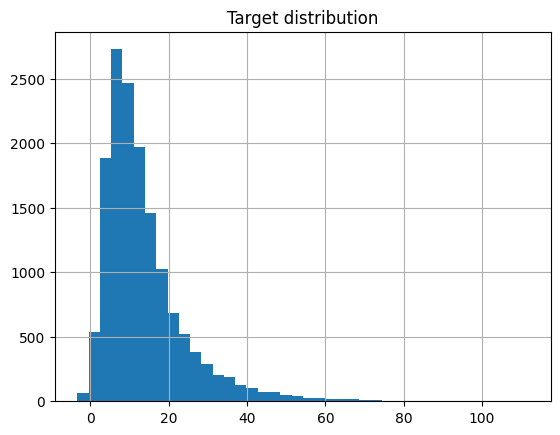

In [10]:
target_col = "target_yield_loss"
cat_cols = ["line_id", "shift", "supplier", "material_grade"]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Shape:", df.shape)
print("\nMissing ratio:")
print(df.isna().mean().sort_values(ascending=False))

print("\nTarget summary:")
print(df[target_col].describe())

plt.figure()
df[target_col].hist(bins=40)
plt.title("Target distribution")
plt.show()


## 4) Train/Validation split

In [11]:
X = df[cat_cols + num_cols].copy()
y = df[target_col].astype(float).copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (12000, 10) Val: (3000, 10)


## 5) 2번: 전처리 파이프라인(범주형/수치형 분리)

### 흔한 실무 선택지(시험에서 감점 없는 선택)
- 범주형: 최빈값 대체 + OneHot
- 수치형: 중앙값 대체 + (StandardScaler 또는 RobustScaler)

> 이상치가 많아 보이면 수치 스케일러를 `RobustScaler`로 바꾸는 것도 좋은 선택입니다.


In [12]:
# 스케일러 선택: 이상치가 많다면 RobustScaler 고려
USE_ROBUST = True

num_scaler = RobustScaler() if USE_ROBUST else StandardScaler()

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", num_scaler)
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_cols),
        ("num", num_pipeline, num_cols)
    ]
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc = preprocess.transform(X_val)

print("Encoded shapes:", X_train_enc.shape, X_val_enc.shape)


Encoded shapes: (12000, 21) (3000, 21)


## 6) (선택) 피처 엔지니어링 테크닉 모음

시험에서 회귀 성능을 올리기 위해 자주 쓰는 “안전한” 테크닉:
- **로그 변환(log1p)**: 한쪽으로 치우친(heavy-tailed) 변수에 사용 (예: `error_cnt`, `vibration_max`)
- **타깃 로그 변환**: 타깃이 heavy-tailed면 `log1p(y)`로 학습 후 `expm1`로 복원  
- **간단 상호작용 피처**: 예) `vibration_max * error_cnt`

> 여기서는 토이데이터에 맞춰 ① 로그변환(수치 raw에서) ② 상호작용 피처를 추가하는 예시를 제공합니다.  
> 시험장에서 데이터 보고 “필요할 때만” 켜면 됩니다.


In [13]:
USE_LOG_FE = True
USE_INTERACTION_FE = True
USE_TARGET_LOG = False  # 타깃 분포가 심하게 치우쳤을 때만 True

def add_fe(df_in: pd.DataFrame) -> pd.DataFrame:
    df2 = df_in.copy()
    if USE_LOG_FE:
        for col in ["error_cnt", "vibration_max"]:
            if col in df2.columns:
                df2[f"log1p_{col}"] = np.log1p(df2[col].clip(lower=0))
    if USE_INTERACTION_FE:
        if ("vibration_max" in df2.columns) and ("error_cnt" in df2.columns):
            df2["vib_x_err"] = df2["vibration_max"].fillna(0) * df2["error_cnt"].fillna(0)
    return df2

X_train_fe = add_fe(X_train)
X_val_fe = add_fe(X_val)

# num_cols 업데이트 (새로 생긴 수치 피처 반영)
num_cols_fe = [c for c in X_train_fe.columns if c not in cat_cols]
print("Added numeric features:", sorted(set(num_cols_fe) - set(num_cols)))

# 전처리 재정의(피처가 추가됐으니 ColumnTransformer도 업데이트)
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", num_scaler)
])
preprocess_fe = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_cols),
        ("num", num_pipeline, num_cols_fe)
    ]
)

X_train_enc = preprocess_fe.fit_transform(X_train_fe)
X_val_enc = preprocess_fe.transform(X_val_fe)

# 타깃 로그 변환 옵션
y_train_fit = np.log1p(y_train) if USE_TARGET_LOG else y_train
y_val_true = y_val  # 평가는 원 스케일에서

print("Encoded(With FE) shapes:", X_train_enc.shape, X_val_enc.shape)


Added numeric features: ['log1p_error_cnt', 'log1p_vibration_max', 'vib_x_err']
Encoded(With FE) shapes: (12000, 24) (3000, 24)


## 7) 3번: 회귀 모델 학습/평가 (MAE/RMSE)

시험 범위에 포함된 대표 모델들을 **빠르게 비교**합니다.
- Linear / Ridge / Lasso (규제)
- RandomForest (비선형/상호작용 강함)
- XGBoost (가능하면 성능 최강 후보)

> 시험에서는 **2개만 비교해도 충분**하지만, 템플릿은 모두 포함합니다.


In [14]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=SEED),
    "Lasso": Lasso(alpha=0.001, random_state=SEED, max_iter=5000),
    "RF": RandomForestRegressor(
        n_estimators=300, random_state=SEED, n_jobs=-1
    ),
}

if HAS_XGB:
    models["XGB"] = XGBRegressor(
        n_estimators=700,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1
    )

results = []
pred_store = {}

for name, model in models.items():
    model.fit(X_train_enc, y_train_fit)
    pred = model.predict(X_val_enc)

    # 타깃 로그 변환 사용 시 복원
    if USE_TARGET_LOG:
        pred = np.expm1(pred)

    pred_store[name] = pred
    results.append([
        name,
        mean_absolute_error(y_val_true, pred),
        rmse(y_val_true, pred),
        r2_score(y_val_true, pred),
    ])

score_df = pd.DataFrame(results, columns=["model","MAE","RMSE","R2"]).sort_values("MAE")
score_df


,model,MAE,RMSE,R2
4,XGB,1.789408,2.780134,0.937163
3,RF,1.814594,2.330781,0.955834
1,Ridge,7.143492,10.501169,0.103485
0,Linear,7.143527,10.501224,0.103475
2,Lasso,7.143645,10.501079,0.103500


## 8) 4번: 지표 최적화(베스트 모델 선택 + (선택) 간단 개선)

가장 MAE가 낮은 모델을 선택합니다.  
시간이 있으면 다음을 시도할 수 있습니다.
- RF: `max_depth`, `min_samples_leaf` 조절
- XGB: `n_estimators`, `max_depth`, `learning_rate` 조절
- Ridge/Lasso: `alpha` 조절

> 시험장에서 과한 튜닝은 시간만 잡아먹을 수 있으니 **작게 1~2번만**.


In [15]:
best_name = score_df.iloc[0]["model"]
best_model = models[best_name]
best_pred = pred_store[best_name]

print("Chosen model:", best_name)
print("MAE :", mean_absolute_error(y_val_true, best_pred))
print("RMSE:", rmse(y_val_true, best_pred))
print("R2  :", r2_score(y_val_true, best_pred))


Chosen model: XGB
MAE : 1.7894075483123337
RMSE: 2.7801344013712304
R2  : 0.9371632076879509


## 9) 5번: 운영 정책(Top 5% 점검 대상) + 리포트

회귀에서의 “Top 5%”는 보통 이렇게 해석됩니다.
- 예측값이 큰 상위 5% 배치 = **손실이 클 것으로 예상 → 사전 점검 대상**
- 현장에선 “리소스 제약” 때문에 Top-N 정책이 매우 흔합니다.

### 출력 컬럼(예시)
`line_id, shift, supplier, material_grade, score(예측값), y_true(실제값), abs_error(옵션)`


In [16]:
# risk score = 예측값(손실이 클수록 위험)
risk_score = best_pred

top5_th = np.percentile(risk_score, 95)
print("Top 5% threshold (pred):", top5_th)

val_report = X_val.copy()
val_report["score"] = risk_score
val_report["y_true"] = y_val_true.values
val_report["abs_error"] = np.abs(val_report["y_true"] - val_report["score"])
val_report["is_top5"] = (val_report["score"] >= top5_th).astype(int)

report_cols = ["line_id","shift","supplier","material_grade","score","y_true","abs_error","is_top5"]
report_top5 = (
    val_report[val_report["is_top5"]==1][report_cols]
    .sort_values("score", ascending=False)
    .head(30)
)

report_top5


Top 5% threshold (pred): 35.240105


,line_id,shift,supplier,material_grade,score,y_true,abs_error,is_top5
6706,1,swing,D,G1,96.831444,57.537122,39.294322,1
2913,2,swing,C,G3,76.924080,60.743438,16.180642,1
11300,5,day,B,G3,76.023376,69.606475,6.416901,1
12165,3,day,B,G2,75.109520,57.983154,17.126366,1
14887,1,swing,B,G2,74.653969,61.188154,13.465815,1
978,2,day,A,G3,72.288002,111.799357,39.511355,1
6786,4,swing,C,G3,70.977089,73.728195,2.751106,1
8001,4,night,A,G3,69.764740,107.181780,37.417040,1
12069,5,night,A,G2,69.454178,60.600539,8.853639,1
12985,5,night,A,G1,69.081383,69.070474,0.010909,1


### (선택) 오차 큰 샘플 리포트 (디버깅/개선 힌트)

시험에서 “이상치/품질 문제를 식별”을 요구하면,  
오차가 큰 샘플을 보는 것이 매우 도움이 됩니다.


In [17]:
report_worst_err = (
    val_report[report_cols]
    .sort_values("abs_error", ascending=False)
    .head(30)
)
report_worst_err


,line_id,shift,supplier,material_grade,score,y_true,abs_error,is_top5
978,2,day,A,G3,72.288002,111.799357,39.511355,1
6706,1,swing,D,G1,96.831444,57.537122,39.294322,1
11843,1,night,C,G3,68.016258,106.046966,38.030708,1
8001,4,night,A,G3,69.764740,107.181780,37.417040,1
5547,1,swing,A,G2,64.901489,101.469141,36.567652,1
10434,4,day,C,G1,57.570808,83.219990,25.649182,1
8410,5,night,B,G1,66.949287,49.718862,17.230425,1
12165,3,day,B,G2,75.109520,57.983154,17.126366,1
2913,2,swing,C,G3,76.924080,60.743438,16.180642,1
10860,1,swing,A,G3,55.132854,70.669491,15.536636,1


## 10) 6번: 모델 해석 — Permutation Importance

시험 범위에서 “모델 해석”을 요구하면 가장 안전한 선택이 **Permutation Importance** 입니다.
- 모델 불문(Linear/RF/XGB 등 어디든 적용 가능)
- 구현 간단
- “어떤 피처가 예측에 중요한지”를 보여줄 수 있음

> 주의: 입력이 희소행렬일 때 feature name 매핑이 복잡할 수 있습니다.  
> 이 템플릿은 **Top 중요도만** 빠르게 확인하는 방식(안정성 우선)으로 제공합니다.


In [18]:
# best_model이 이미 학습됨
# permutation_importance는 scoring을 문자열로 주면 편함. 회귀는 'neg_mean_absolute_error'가 자주 쓰임.
perm = permutation_importance(
    best_model, X_val_enc, y_val_true,
    n_repeats=5, random_state=SEED,
    scoring="neg_mean_absolute_error"
)

importances = perm.importances_mean
# feature name 추출(가능한 경우)
try:
    feature_names = preprocess_fe.get_feature_names_out()
except Exception:
    feature_names = np.array([f"f{i}" for i in range(len(importances))])

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

imp_df.head(30)


,feature,importance
19,num__cycle_time,7.619204
23,num__vib_x_err,0.695690
11,cat__supplier_D,0.559235
14,cat__material_grade_G3,0.314276
15,num__temp_mean,0.228598
20,num__error_cnt,0.118968
17,num__vibration_max,0.061637
10,cat__supplier_C,0.055697
21,num__log1p_error_cnt,0.013502
22,num__log1p_vibration_max,0.002200


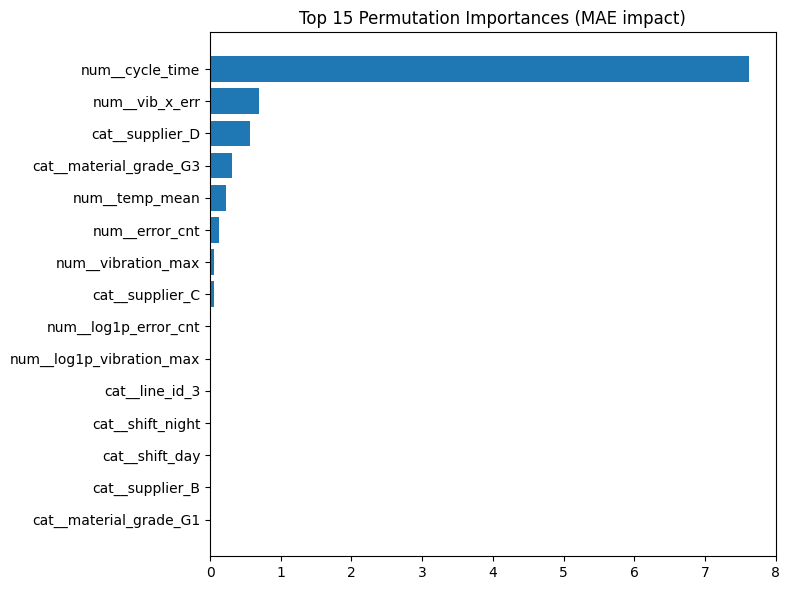

In [19]:
plt.figure(figsize=(8,6))
topk = 15
plt.barh(imp_df.head(topk)["feature"][::-1], imp_df.head(topk)["importance"][::-1])
plt.title(f"Top {topk} Permutation Importances (MAE impact)")
plt.tight_layout()
plt.show()


## 11) 시험장에서 복붙할 때 “바꾸는 곳” 체크리스트 (회귀)

### 1) 파일/컬럼명
- `CSV_PATH` (toy 생성 대신 `pd.read_csv`)
- `target_col`
- `cat_cols` / `num_cols`

### 2) 전처리 선택
- 이상치 많으면 `USE_ROBUST=True`
- 수치 스케일링이 불필요해 보이면(트리만 쓸 때) scaler 제거도 가능(하지만 일반적으로 유지 추천)

### 3) 피처 엔지니어링(필요할 때만 켜기)
- `USE_LOG_FE`, `USE_INTERACTION_FE`, `USE_TARGET_LOG`

### 4) 모델
- **시간 부족**: Ridge 1개 + RF 1개만
- **성능 욕심**: XGB 추가

### 5) 운영 리포트
- 문제에서 Top 3%/10% 등 요구하면 `np.percentile(risk_score, 97)`처럼 수정

---

## ✅ 회귀 유형에서 채점자가 “바로 체크”하는 것
- MAE/RMSE 출력 ✅
- 전처리(범주/수치 분리) ✅
- (있으면 가산) 피처 엔지니어링 ✅
- (있으면 가산) 모델 2개 이상 비교 ✅
- (운영 관점) Top-N 리포트 ✅
- (해석) Permutation importance ✅
